# 1. Initial Setup and General Functions

In [5]:
import pandas as pd
import numpy as np
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

# --- 1. SETTINGS AND GENERAL FUNCTIONS ---

# Set the sampling rate of the EDA signal
SAMPLING_RATE = 15 # Hz

def analyze_eda_segment(eda_data, sampling_rate=15):
    """
    Cleans EDA signal and extracts key metrics for a single segment.
    """
    if eda_data.empty:
        return None

    # 1. Clean the signal
    eda_cleaned = nk.eda_clean(eda_data, sampling_rate=sampling_rate)

    # 2. Decompose into tonic (SCL) and phasic (SCR) components
    eda_decomposed = nk.eda_phasic(eda_cleaned, sampling_rate=sampling_rate)
    
    # 3. Detect SCR peaks
    peaks, info = nk.eda_peaks(eda_decomposed['EDA_Phasic'], sampling_rate=sampling_rate)
    
    # 4. Extract metrics
    metrics = {}
    metrics['mean_scl'] = np.mean(eda_decomposed['EDA_Tonic'])
    
    metrics['num_scrs'] = len(info.get('SCR_Peaks', []))
    
    scr_amplitudes = info.get('SCR_Amplitudes', [])
    metrics['avg_scr_amplitude'] = np.mean(scr_amplitudes) if len(scr_amplitudes) > 0 else 0
    
    return metrics

# 2. Data Loading and Segmentation

In [6]:
# --- 2. DATA LOADING & MULTI-SESSION SEGMENTATION ---

# Define the file paths and segment indices for all four sessions.
# The file paths have been updated to target EDA data.
all_sessions_info = {
    "Aug 5 Afternoon": {
        "filepath": "../PwD dataset/August 5 Afternoon AF 000233/2025-08-05_14-53-04-489951_EA.csv",
        "segments_indices": [(0, 6300), (6300, 11700), (11700, 14370), (-8100, None)]
    },
    "July 22 Afternoon": {
        "filepath": "../PwD dataset/July 22 Afternoon AF 000233/2025-07-22_15-09-31-076964_EA.csv",
        "segments_indices": [(0, 14805), (17055, 19725), (-25200, -21000), (-6300, None)]
    },
    "Aug 5 Morning": {
        "filepath": "../PwD dataset/August 5 Morning AF 000233/2025-08-05_11-19-32-408946_EA.csv",
        "segments_indices": [(0, 11700), (11700, 15750), (15750, 18420), (-7530, None)]
    },
    "July 22 Morning": {
        "filepath": "../PwD dataset/July 22 Morning AF 000233/2025-07-22_10-11-31-907316_EA.csv",
        "segments_indices": [(0, 11700), (57600, 60300), (60300, 63000), (-3600, None)]
    }
}

# This dictionary will store the segmented data for all sessions.
all_session_data = {}

for session_name, info in all_sessions_info.items():
    print(f"\nLoading and segmenting data for session: {session_name}...")
    try:
        df_eda = pd.read_csv(info["filepath"])
        eda_signal = df_eda["EA"]
        session_segments = {}
        for i, (start, end) in enumerate(info["segments_indices"]):
            segment_name = f"Segment {i+1}"
            actual_start = start if start >= 0 else len(eda_signal) + start
            actual_end = end if end is not None and end >= 0 else (len(eda_signal) + end if end is not None else None)
            if actual_start < len(eda_signal):
                session_segments[segment_name] = eda_signal.iloc[actual_start:actual_end].copy()
            else:
                print(f"  Warning: Segment {i+1} start index is out of bounds. Skipping.")
        all_session_data[session_name] = session_segments
        print(f"  Successfully loaded and segmented {session_name}.")
    except FileNotFoundError:
        print(f"  Error: File not found for {session_name} at path '{info['filepath']}'. Skipping this session.")
    except KeyError:
        print(f"  Error: 'EA' column not found in file for {session_name}. Skipping this session.")
        
print("\nAll sessions loaded and segmented. Ready for analysis.")


Loading and segmenting data for session: Aug 5 Afternoon...
  Successfully loaded and segmented Aug 5 Afternoon.

Loading and segmenting data for session: July 22 Afternoon...
  Successfully loaded and segmented July 22 Afternoon.

Loading and segmenting data for session: Aug 5 Morning...
  Successfully loaded and segmented Aug 5 Morning.

Loading and segmenting data for session: July 22 Morning...
  Successfully loaded and segmented July 22 Morning.

All sessions loaded and segmented. Ready for analysis.


# 3. EDA Analysis and Metrics Extraction

In [7]:
# --- 3. EDA ANALYSIS AND METRICS EXTRACTION ---

all_session_eda_metrics = {}
for session_name, segments in all_session_data.items():
    print(f"\nPerforming EDA analysis for {session_name}...")
    session_metrics = {}
    for segment_name, data in segments.items():
        if not data.empty:
            metrics = analyze_eda_segment(data, sampling_rate=SAMPLING_RATE)
            if metrics:
                session_metrics[segment_name] = metrics
                print(f"  '{session_name} - {segment_name}' Metrics:")
                print(f"    Mean SCL: {metrics['mean_scl']:.3f}")
                print(f"    Number of SCRs: {metrics['num_scrs']}")
                print(f"    Avg SCR Amplitude: {metrics['avg_scr_amplitude']:.3f}")
            else:
                print(f"  Warning: No valid metrics extracted for '{session_name} - {segment_name}'.")
        else:
            print(f"  Warning: Skipping '{session_name} - {segment_name}' due to empty data.")
    all_session_eda_metrics[session_name] = session_metrics


Performing EDA analysis for Aug 5 Afternoon...
  'Aug 5 Afternoon - Segment 1' Metrics:
    Mean SCL: 0.456
    Number of SCRs: 54
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 2' Metrics:
    Mean SCL: 0.783
    Number of SCRs: 50
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 3' Metrics:
    Mean SCL: 0.997
    Number of SCRs: 11
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 4' Metrics:
    Mean SCL: 1.677
    Number of SCRs: 26
    Avg SCR Amplitude: 0.000

Performing EDA analysis for July 22 Afternoon...
  'July 22 Afternoon - Segment 1' Metrics:
    Mean SCL: 1.095
    Number of SCRs: 90
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 2' Metrics:
    Mean SCL: 1.625
    Number of SCRs: 21
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 3' Metrics:
    Mean SCL: 3.922
    Number of SCRs: 77
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 4' Metrics:
    Mean SCL: 6.882
    Number of SCRs: 42
    Avg SCR Amplitu

In [8]:
# --- 3. EDA ANALYSIS AND METRICS EXTRACTION ---

all_session_eda_metrics = {}
for session_name, segments in all_session_data.items():
    print(f"\nPerforming EDA analysis for {session_name}...")
    session_metrics = {}
    for segment_name, data in segments.items():
        if not data.empty:
            metrics = analyze_eda_segment(data, sampling_rate=SAMPLING_RATE)
            if metrics:
                session_metrics[segment_name] = metrics
                print(f"  '{session_name} - {segment_name}' Metrics:")
                print(f"    Mean SCL: {metrics['mean_scl']:.3f}")
                print(f"    Number of SCRs: {metrics['num_scrs']}")
                print(f"    Avg SCR Amplitude: {metrics['avg_scr_amplitude']:.3f}")
            else:
                print(f"  Warning: No valid metrics extracted for '{session_name} - {segment_name}'.")
        else:
            print(f"  Warning: Skipping '{session_name} - {segment_name}' due to empty data.")
    all_session_eda_metrics[session_name] = session_metrics


Performing EDA analysis for Aug 5 Afternoon...
  'Aug 5 Afternoon - Segment 1' Metrics:
    Mean SCL: 0.456
    Number of SCRs: 54
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 2' Metrics:
    Mean SCL: 0.783
    Number of SCRs: 50
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 3' Metrics:
    Mean SCL: 0.997
    Number of SCRs: 11
    Avg SCR Amplitude: 0.000
  'Aug 5 Afternoon - Segment 4' Metrics:
    Mean SCL: 1.677
    Number of SCRs: 26
    Avg SCR Amplitude: 0.000

Performing EDA analysis for July 22 Afternoon...
  'July 22 Afternoon - Segment 1' Metrics:
    Mean SCL: 1.095
    Number of SCRs: 90
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 2' Metrics:
    Mean SCL: 1.625
    Number of SCRs: 21
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 3' Metrics:
    Mean SCL: 3.922
    Number of SCRs: 77
    Avg SCR Amplitude: 0.000
  'July 22 Afternoon - Segment 4' Metrics:
    Mean SCL: 6.882
    Number of SCRs: 42
    Avg SCR Amplitu

# 4. Calculate SCR Frequency 

In [9]:
# --- 4. CALCULATE AND ADD SCR FREQUENCY METRIC ---

print("\n--- Calculating and adding SCR Frequency metric ---")

for session_name, segments in all_session_data.items():
    for segment_name, data in segments.items():
        # Get the existing metrics for the segment
        metrics = all_session_eda_metrics[session_name][segment_name]
        
        # Calculate the duration of the segment in seconds
        segment_duration_seconds = len(data) / SAMPLING_RATE
        
        # Calculate SCRs per minute
        if segment_duration_seconds > 0:
            scr_frequency_per_min = (metrics['num_scrs'] / segment_duration_seconds) * 60
        else:
            scr_frequency_per_min = 0

        # Add the new metric to the dictionary
        all_session_eda_metrics[session_name][segment_name]['scr_frequency_per_min'] = scr_frequency_per_min
        print(f"  '{session_name} - {segment_name}' SCR Frequency: {scr_frequency_per_min:.2f} per minute")


--- Calculating and adding SCR Frequency metric ---
  'Aug 5 Afternoon - Segment 1' SCR Frequency: 7.71 per minute
  'Aug 5 Afternoon - Segment 2' SCR Frequency: 8.33 per minute
  'Aug 5 Afternoon - Segment 3' SCR Frequency: 3.71 per minute
  'Aug 5 Afternoon - Segment 4' SCR Frequency: 2.89 per minute
  'July 22 Afternoon - Segment 1' SCR Frequency: 5.47 per minute
  'July 22 Afternoon - Segment 2' SCR Frequency: 7.08 per minute
  'July 22 Afternoon - Segment 3' SCR Frequency: 16.50 per minute
  'July 22 Afternoon - Segment 4' SCR Frequency: 6.00 per minute
  'Aug 5 Morning - Segment 1' SCR Frequency: 0.77 per minute
  'Aug 5 Morning - Segment 2' SCR Frequency: 7.11 per minute
  'Aug 5 Morning - Segment 3' SCR Frequency: 5.39 per minute
  'Aug 5 Morning - Segment 4' SCR Frequency: 7.89 per minute
  'July 22 Morning - Segment 1' SCR Frequency: 2.08 per minute
  'July 22 Morning - Segment 2' SCR Frequency: 9.33 per minute
  'July 22 Morning - Segment 3' SCR Frequency: 8.00 per minute
 

# 5. Visualization of SCR Frequency


--- Generating Bar Charts for SCR Frequency ---


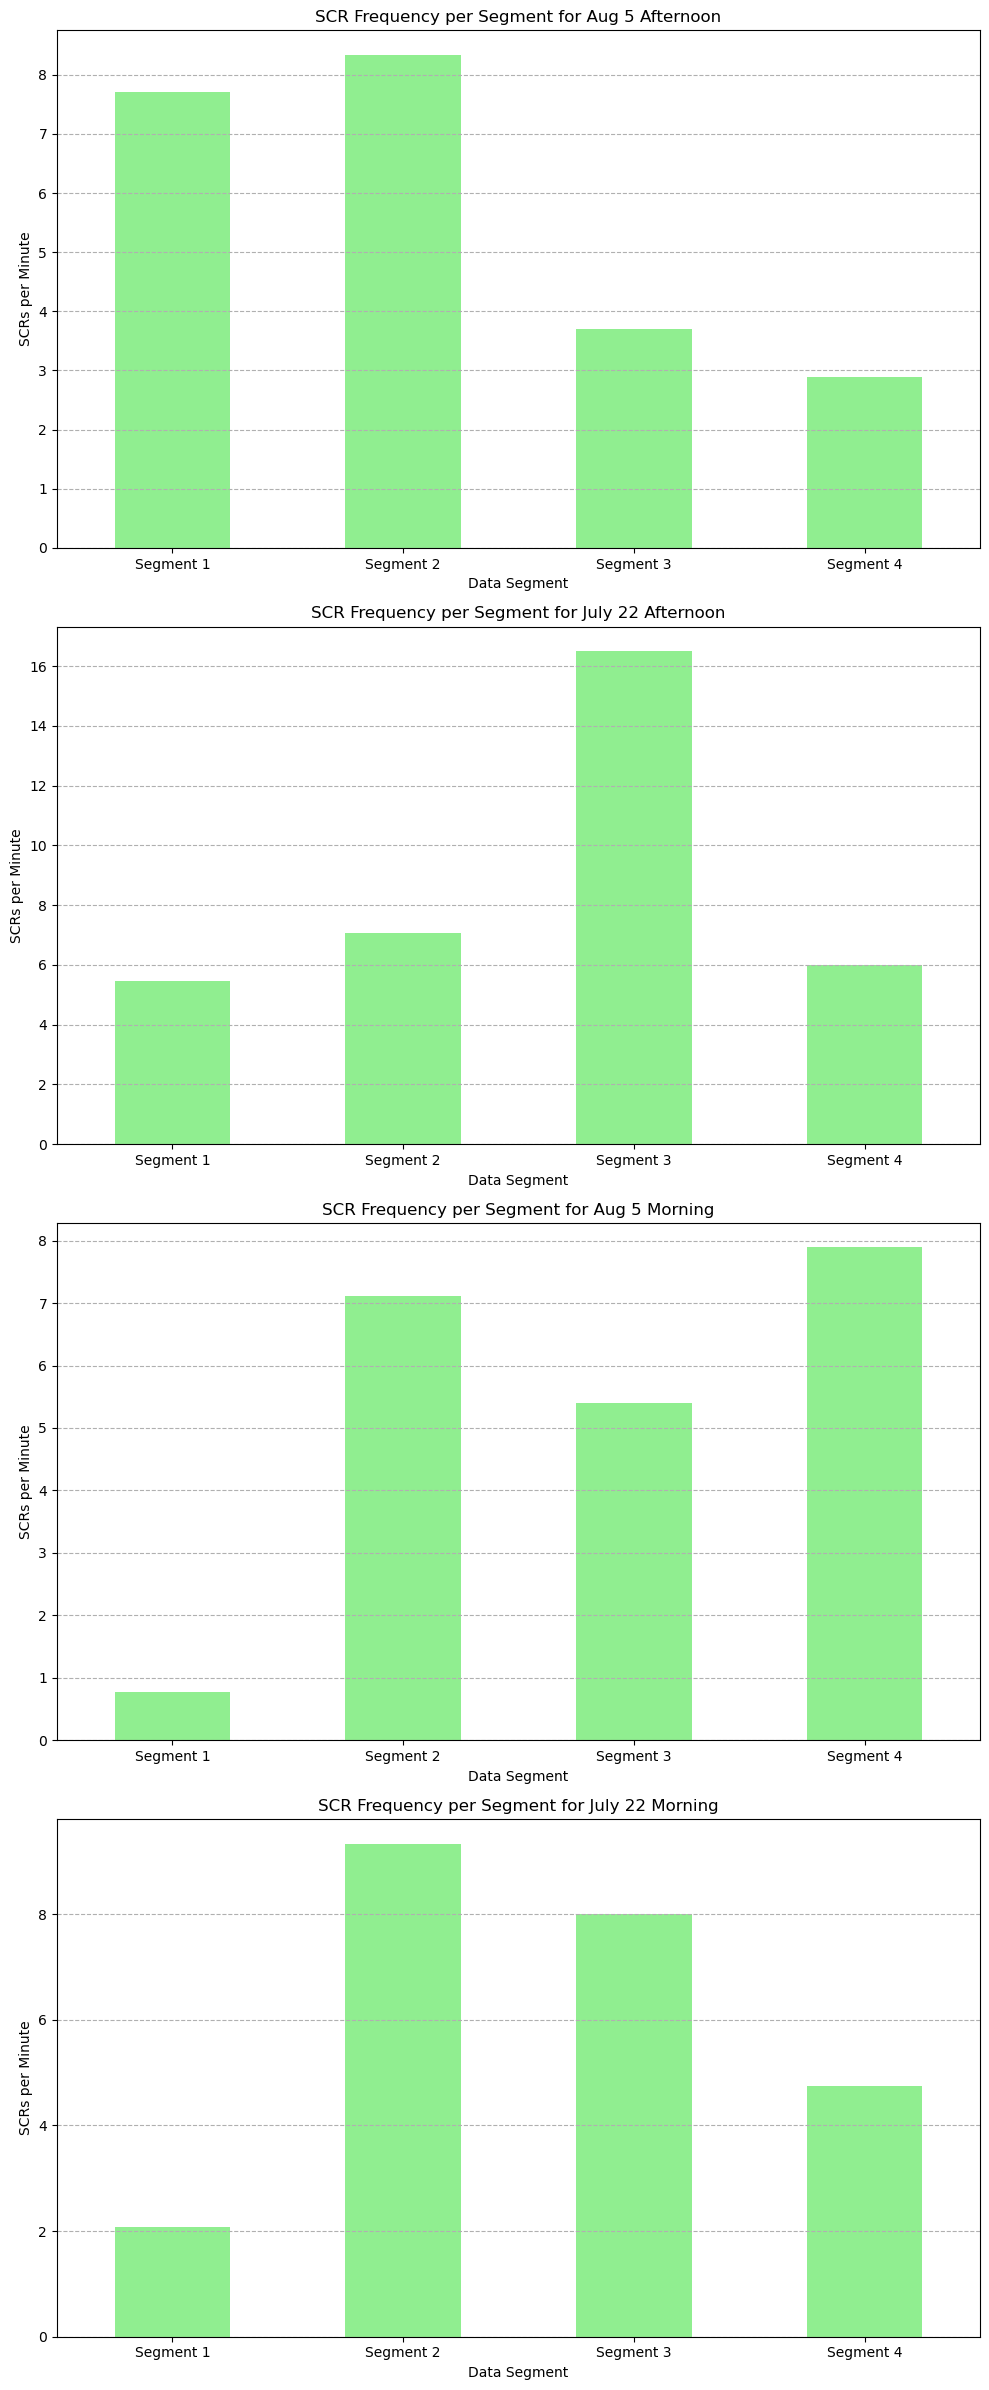

In [10]:
# --- 5. VISUALIZATION OF SCR FREQUENCY ---

print("\n--- Generating Bar Charts for SCR Frequency ---")

num_sessions = len(all_session_eda_metrics)
fig, axes = plt.subplots(nrows=num_sessions, ncols=1, figsize=(10, 6 * num_sessions))

if num_sessions == 1:
    axes = [axes]

for i, (session_name, metrics_data) in enumerate(all_session_eda_metrics.items()):
    metrics_df = pd.DataFrame(metrics_data).T
    if not metrics_df.empty:
        metrics_df['scr_frequency_per_min'].plot(kind='bar', rot=0, ax=axes[i], color='lightgreen')
        axes[i].set_title(f"SCR Frequency per Segment for {session_name}")
        axes[i].set_ylabel("SCRs per Minute")
        axes[i].set_xlabel("Data Segment")
        axes[i].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()